In [1]:
import os
import pickle as pkl

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from hyperopt import space_eval
from hyperopt import hp
from least_squares_hyperopt import least_squares_predict

/Users/chaaland/miniconda3/envs/HandsOnML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chaaland/miniconda3/envs/HandsOnML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chaaland/miniconda3/envs/HandsOnML/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chaaland/miniconda

# Model Fitting

In [14]:
%run least_squares_hyperopt.py --n-trials=200 --hyperopt-trials "ridge_regression.pkl"

No saved HyperOpt Trials object found. Starting from scratch
100%|██████████| 400/400 [01:30<00:00,  4.40it/s, best loss: 0.01616778752537251]
Best validation accuracy: 0.01617
Best params: {'alpha': 123.60569946236828, 'n_lags': 4}


In [14]:
with open("ridge_regression.pkl", "rb") as f:
    hyperopt_ridge_trial = pkl.load(f)

In [15]:
hyperopt_ridge_trial.argmin

{'alpha': 123.60569946236828, 'n_lags': 4}

In [16]:
hyperopt_ridge_trial.best_trial

{'state': 2,
 'tid': 368,
 'spec': None,
 'result': {'loss': 0.01616778752537251,
  'status': 'ok',
  'train_validation_time': 0.2402048110961914},
 'misc': {'tid': 368,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'alpha': [368], 'n_lags': [368]},
  'vals': {'alpha': [123.60569946236828], 'n_lags': [4]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 9, 1, 17, 25, 37, 44000),
 'refresh_time': datetime.datetime(2019, 9, 1, 17, 25, 37, 287000)}

In [17]:
space = {
    "n_lags": hp.choice("n_lags", [2**i for i in range(3,9)]),
    "alpha": hp.loguniform("alpha", np.log(0.0001), np.log(1000)),
}

In [18]:
best_params = space_eval(space, hyperopt_ridge_trial.argmin)

In [19]:
best_params

{'alpha': 123.60569946236828, 'n_lags': 128}

In [21]:
df = pd.read_parquet(os.path.join("data", "preprocessed", "df_log_features.parquet"))
pred_df = least_squares_predict(df_log_features, train_start_date, train_end_date, **best_params)
# TODO: Use this logic to get back the predicted prices. 
# Exponentiate and multiply by shifted version of orig prices (since we want p_{t-1} * r_t)

In [32]:
# TODO: Get the stddev of train and validation so we have a baseline for improvement!
y_train = df_log_features["Adj Close"][(train_start_date <= df_log_features.index.get_level_values(1)) & (df_log_features.index.get_level_values(1) <= train_end_date)].values
y_validation = df_log_features["Adj Close"][(validation_start_date <= df_log_features.index.get_level_values(1)) & (df_log_features.index.get_level_values(1) <= validation_end_date)].values

In [33]:
print(f"Baseline training mse: {y_train.std()}")
print(f"Baseline validation mse: {y_validation.std()}")

Baseline training mse: 0.033329236367167066
Baseline validation mse: 0.016169250353716417


In [26]:
pred_df.head()

0
Symbol Date                
AAPL   1981-06-18  0.000388
       1981-06-19  0.000147
       1981-06-22  0.000741
       1981-06-23  0.000487
       1981-06-24  0.000981

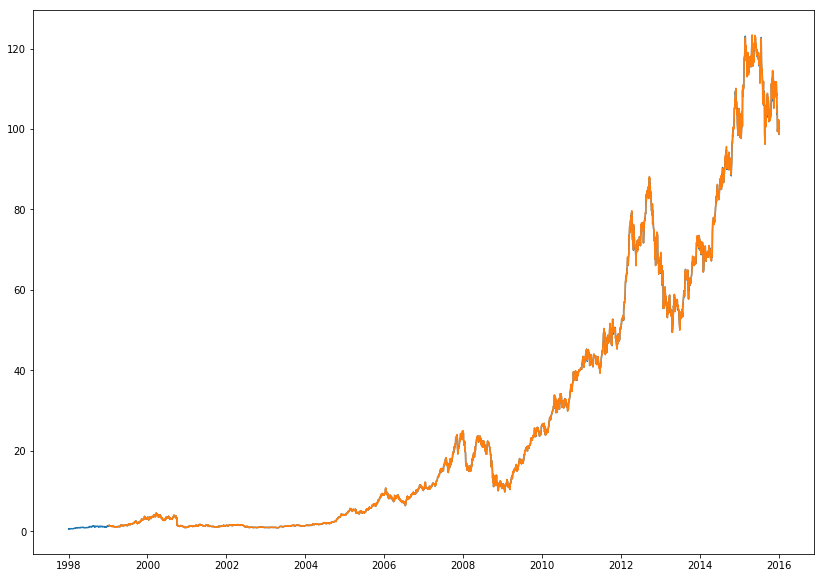

In [34]:
plt.figure(figsize=(14,10))

for symbol, sub_df in df_train.groupby(level=0):
    plt.plot(sub_df.index.get_level_values(1), sub_df["Adj Close"])
    break
    
for symbol, sub_df in train_pred_response.groupby(level=0):
    plt.plot(sub_df.index.get_level_values(1), sub_df["Predicted Price"])
    break

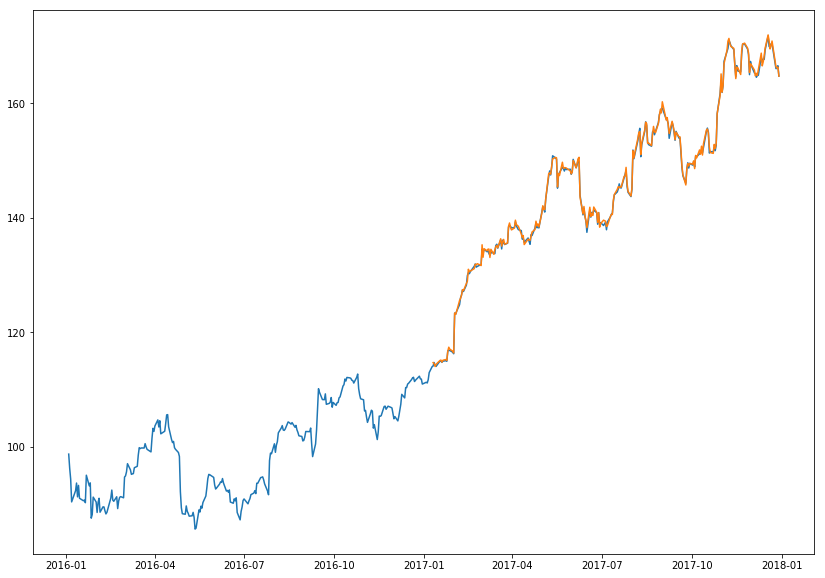

In [66]:
plt.figure(figsize=(14,10))

for symbol, sub_df in df_validation.groupby(level=0):
    plt.plot(sub_df.index.get_level_values(1), sub_df["Adj Close"])
    break
    
for symbol, sub_df in validation_pred_response.groupby(level=0):
    plt.plot(sub_df.index.get_level_values(1), sub_df["Predicted Price"])
    break

In [ ]:
# TODO: Get a dataframe containing both yhat and ytrue. Filter the dates to get train and validation correlations
df_train_pred_true = df_log_features[["Adj Close"]].join(pred_df, how="inner")


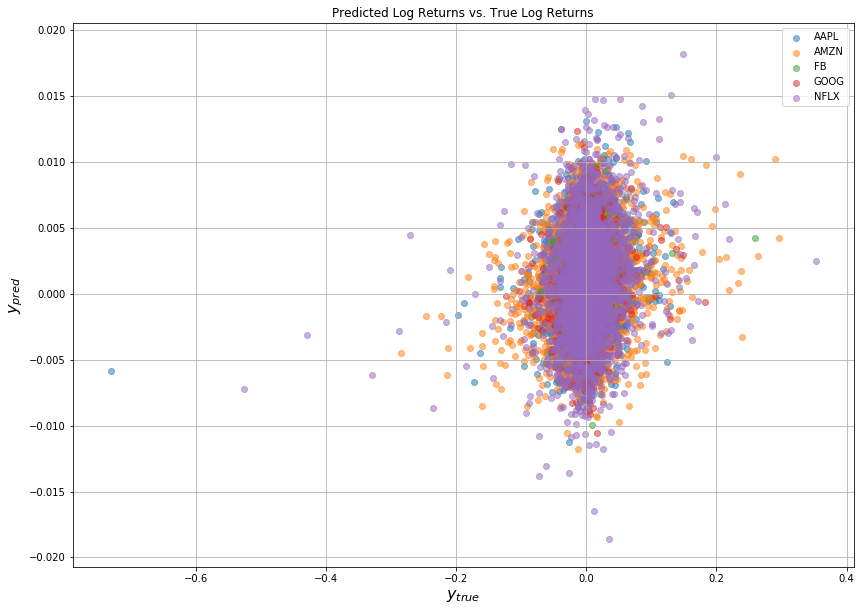

In [63]:
plt.figure(figsize=(14,10))

for (symbol, sub_df), i in zip(df_train_pred_true.groupby(level=0), [3,4,7,8,11,12]):
    plt.scatter(sub_df["Adj Close"], sub_df["Predicted Log Returns"], alpha=0.5, label=symbol);

plt.grid(True);
plt.legend()
plt.xlabel(r"$y_{true}$", fontsize=16);
plt.ylabel(r"$y_{pred}$", fontsize=16);
plt.title("Predicted Log Returns vs. True Log Returns");

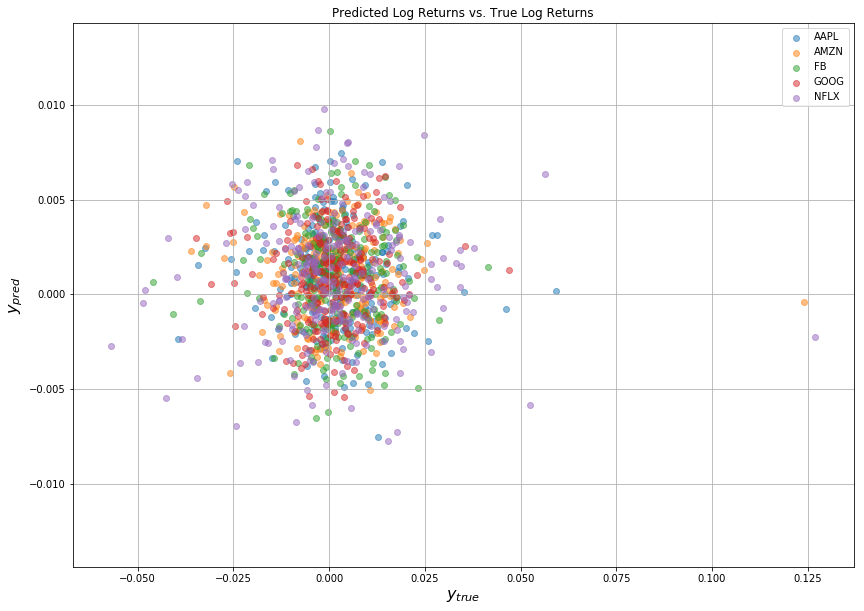

In [67]:
plt.figure(figsize=(14,10))

df_validation_pred_true = df_validation_features[["Adj Close"]].join(validation_pred_df, how="inner")
for (symbol, sub_df), i in zip(df_validation_pred_true.groupby(level=0), [3,4,7,8,11,12]):
    plt.scatter(sub_df["Adj Close"], sub_df["Predicted Log Returns"], alpha=0.5, label=symbol);

plt.grid(True);
plt.legend()
plt.xlabel(r"$y_{true}$", fontsize=16);
plt.ylabel(r"$y_{pred}$", fontsize=16);
plt.title("Predicted Log Returns vs. True Log Returns");

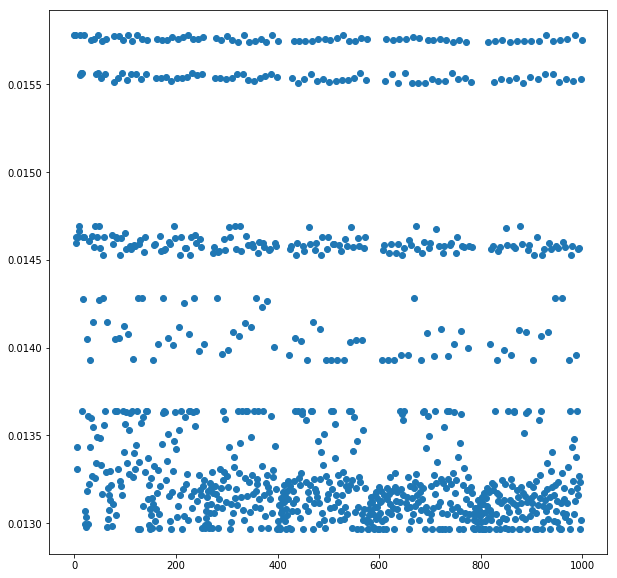

In [60]:
plt.figure(figsize=(10,10))
plt.plot([elem["result"]["loss"] for elem in hyperopt_ridge_trial.trials], linestyle="None", marker="o");

In [62]:
result = train_pred.join(train_pred, how="outer", lsuffix="l", rsuffix="r")
result.head()

0l        0r
Symbol Date                          
AAPL   1999-01-11  0.001837  0.001837
       1999-01-12  0.002969  0.002969
       1999-01-13  0.001277  0.001277
       1999-01-14 -0.002588 -0.002588
       1999-01-15  0.003167  0.003167